In [31]:
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

import os
data_path = os.environ.get('PROJECT_DATA')

import numpy as np
import pandas as pd
import datetime


def try_parsing_date(text):
    """
    Parse dates with different formats.
    
    This is required to correctly parse the dates in the gridwatch data.
    """
    for fmt in ("%Y-%m-%d %H:%M", "%Y-%m-%d %H:%M:%S", "%d/%m/%Y %H:%M", " %Y-%m-%d %H:%M:%S", "%d/%m/%Y"):
        try:
             return datetime.datetime.strptime(text, fmt)
        except ValueError:
            pass
    raise ValueError("No valid date format found.")


class DataGetter:
    '''
    Stores datapaths and methods to retrieve it
    If the class is provided snapshots, all passed dataframes will have
        dataframe.index = snapshots
    '''
    def __init__(self,
                 snapshots=None,
                 elec_cost_path=None,
                 heat_demand_path=None,
                 elec_demand_path=None):
        '''
        Sets up paths
        '''

        self.snapshots = snapshots
        if snapshots is not None:
            self.freq = pd.infer_freq(snapshots)
        else:
            self.freq = None

        self.elec_cost_path = elec_cost_path or os.path.join(data_path, 
                                            'agileout.csv')
        self.elec_demand_path = elec_demand_path or os.path.join(data_path, 
                                            'UoE_energy_data', 
                                            'AMR_Data_for_meter_0795NE003V_Easter Bush Elec.XLSX',)
        self.heat_demand_path = heat_demand_path or os.path.join(data_path, 
                                            'UoE_energy_data', 
                                            'AMR_Data_for_meter_0795NH001S_Easter Bush Heat.XLSX',)
                        
    
    def get_demand_data(self):
        '''
        Loads data from easter bush sensors and rearranges it to a dataframe with time index

        Args:
            -

        Returns:
            df_heat(pd.DataFrame): heat demand data
            df_elec(pd.DataFrame): electricity demand data

        '''

        elec_demand = self.elec_demand_path
        heat_demand = self.heat_demand_path

        # Read data and parse the date
        df_elec = pd.read_excel(elec_demand, parse_dates=True, date_parser=try_parsing_date, index_col='(Data is in GMT Format)')
        df_elec = df_elec.rename(columns=lambda x: x.strip())  # some column names begin with a space

        # Read data and parse the date
        df_heat = pd.read_excel(heat_demand, parse_dates=True, date_parser=try_parsing_date, index_col='(Data is in GMT Format)')
        df_heat = df_heat.rename(columns=lambda x: x.strip())  # some column names begin with a space

        def fix_df_shape(df):
            # Remove all but the time columns
            df2 = df.filter(df.columns[5:5+48], axis=1)

            #convert all times to timedelta
            df2.columns = pd.to_timedelta(df2.columns + ':00')

            # Stack and change index from date to datetime
            df_st = df2.stack()
            df_st = pd.DataFrame(df_st) 
            df_st.index = df_st.index.get_level_values(0) + df_st.index.get_level_values(1)
            df_st.columns = ['Values']

            return df_st

        # Check dataframe
        df_heat = fix_df_shape(df_heat)
        df_elec = fix_df_shape(df_elec)

        if self.snapshots is not None:
            df_heat = df_heat.resample(self.freq).sum() 
            df_elec = df_elec.resample(self.freq).sum() 
            
            df_heat = df_heat.loc[self.snapshots]
            df_elec = df_elec.loc[self.snapshots]

        return df_heat, df_elec


    def get_market_data(self):
        '''
        Obtains time series of wholesale electricity prices
        Also passes a time series of gas prices
        '''


        eprices = pd.read_csv(self.elec_cost_path, parse_dates=True, header=None, index_col=0)

        eprices = eprices.rename(columns={4: 'price'})
        eprices = eprices[['price']]

        eprices.index = eprices.index - pd.Timedelta(weeks=52)

        if self.snapshots is not None:

            eprices = eprices.resample(self.freq).mean()
            eprices = eprices.loc[self.snapshots[0]:self.snapshots[-1]]

        gasprices = pd.DataFrame({'price': pd.Series(np.ones(len(eprices)) * eprices.price.mean() / 4)})
        gasprices.index = eprices.index
        

        return gasprices, eprices

if __name__ == '__main__':
    import matplotlib.pyplot as plt
    plt.style.use('bmh')

    snapshots = pd.date_range('2019-01-01', '2019-02-01', freq='30min')
    getter = DataGetter(snapshots=snapshots)

    heat, elec = getter.get_demand_data()
    gascost, ecost = getter.get_market_data()

C:\Users\s2216495\AppData\Local\Programs\Python\Python38\lib\site-packages\openpyxl\styles\stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
C:\Users\s2216495\AppData\Local\Temp/ipykernel_12156/1074544636.py:130: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future version.  Use a timezone-aware object instead.
  eprices = eprices.loc[self.snapshots[0]:self.snapshots[-1]]


In [33]:
print(ecost.price.mean())

4.899361987911364


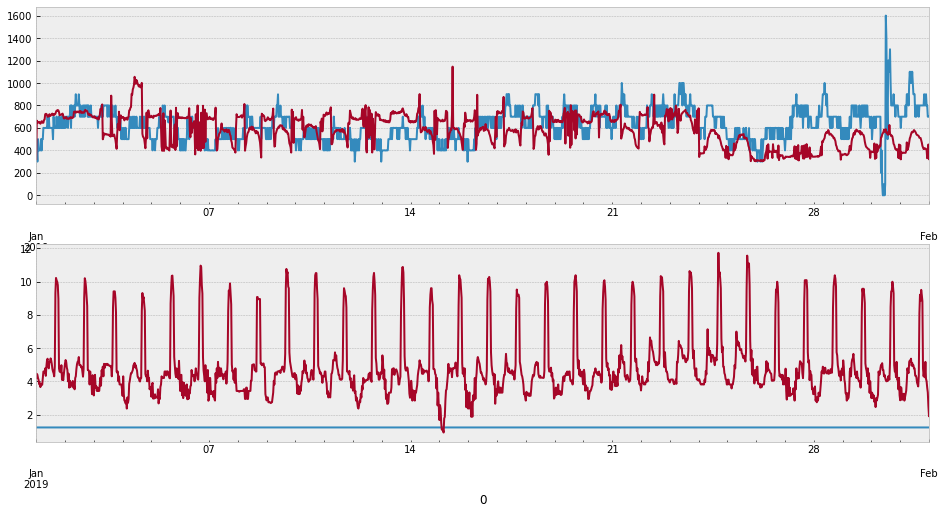

In [35]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

heat.Values.plot(ax=axs[0], label='heat')
elec.Values.plot(ax=axs[0], label='elec')

gascost.price.plot(ax=axs[1], label='gas')
ecost.price.plot(ax=axs[1], label='elec')

plt.show()

In [11]:
pd.date_range('2020-01-01', '2021-01-01', freq='30min')

DatetimeIndex(['2020-01-01 00:00:00', '2020-01-01 00:30:00',
               '2020-01-01 01:00:00', '2020-01-01 01:30:00',
               '2020-01-01 02:00:00', '2020-01-01 02:30:00',
               '2020-01-01 03:00:00', '2020-01-01 03:30:00',
               '2020-01-01 04:00:00', '2020-01-01 04:30:00',
               ...
               '2020-12-31 19:30:00', '2020-12-31 20:00:00',
               '2020-12-31 20:30:00', '2020-12-31 21:00:00',
               '2020-12-31 21:30:00', '2020-12-31 22:00:00',
               '2020-12-31 22:30:00', '2020-12-31 23:00:00',
               '2020-12-31 23:30:00', '2021-01-01 00:00:00'],
              dtype='datetime64[ns]', length=17569, freq='30T')